# Human vs Agent Efficiency

Summary of Key Metrics and Variance Scores:

--- Mile Efficiency ---
Asset v101: 22.46
Asset v102: 38.39
Asset v104: 112.22
Asset v105: 27.61
Asset v106: 12.30
Asset v107: 33.33
Asset v108: 206.25
Asset v109: 78.71
Asset v201: 64.51
Asset v202: 23.76
Total variance for Mile Efficiency: 3167.24
Standard deviation for Mile Efficiency: 56.28

--- Time Efficiency ---
Asset v101: 194.97
Asset v102: 177.93
Asset v104: 200.06
Asset v105: 202.65
Asset v106: 223.68
Asset v107: 200.51
Asset v108: 171.36
Asset v109: 67.76
Asset v201: 151.39
Asset v202: 187.45
Total variance for Time Efficiency: 1696.97
Standard deviation for Time Efficiency: 41.19

--- Average Closeness ---
Asset v101: 3.41
Asset v102: 8.00
Asset v104: 10.71
Asset v105: 5.82
Asset v106: 3.35
Asset v107: 6.69
Asset v108: 20.45
Asset v109: 8.72
Asset v201: 10.41
Asset v202: 3.99
Total variance for Average Closeness: 23.38
Standard deviation for Average Closeness: 4.83

--- Asset Downtime ---
Asset v101: 1.45
Asset v102: 1.47
Asset 

C:\Users\cyberwitch\AppData\Local\Temp\ipykernel_17528\3485706445.py:208: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  schedule['pickup_time'] = pd.to_datetime(schedule['pickup_time'])
C:\Users\cyberwitch\AppData\Local\Temp\ipykernel_17528\3485706445.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedule.groupby('asset').apply(calculate_average_closeness).to_dict()
C:\Users\cyberwitch\AppData\Local\Temp\ipykernel_17528\3485706445.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a f

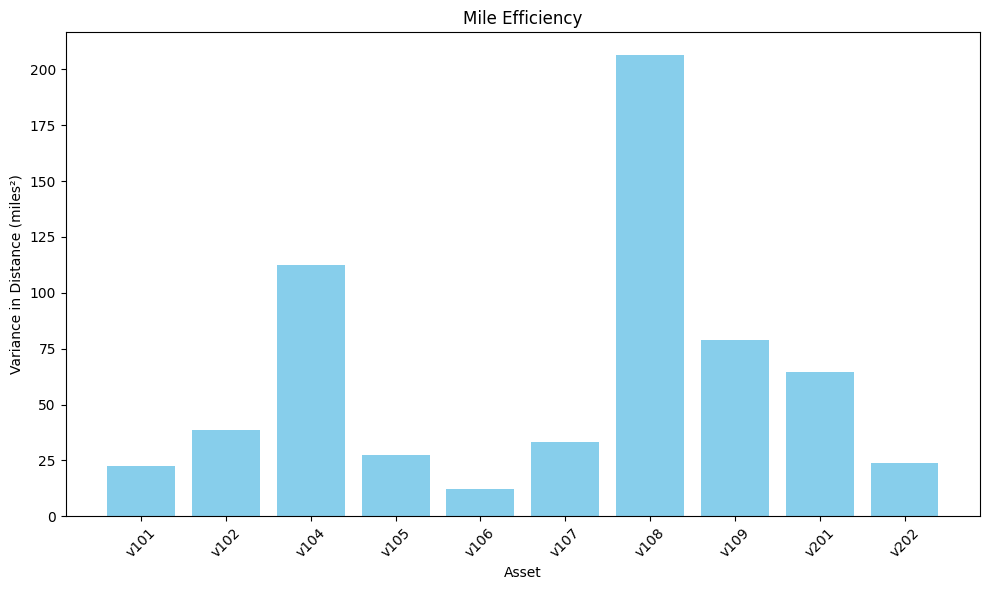

The bar chart above shows the Mile Efficiency for each asset. This helps visualize the efficiency of each asset in terms of the specific metric. Lower values indicate better performance for each metric.


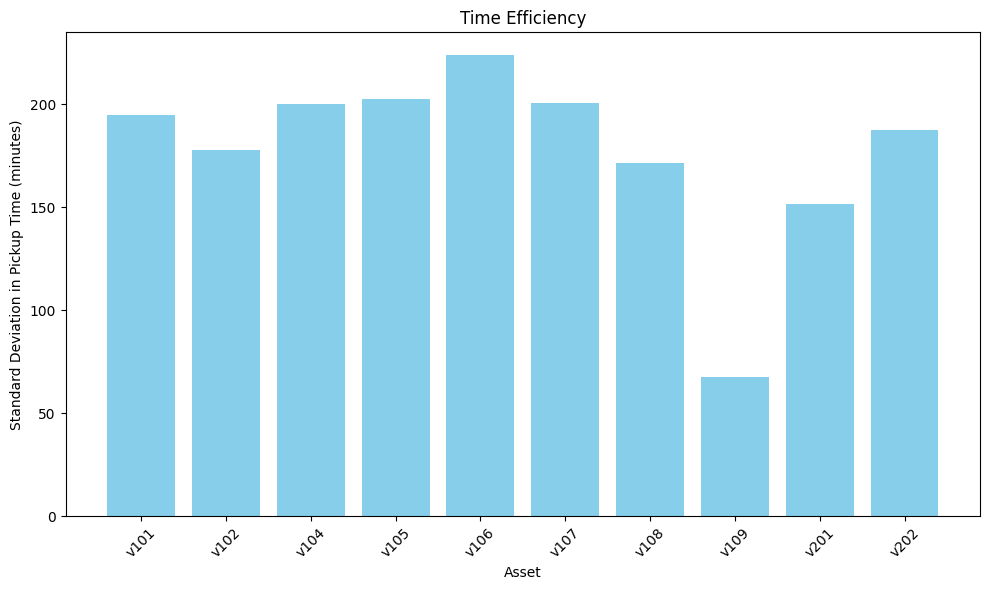

The bar chart above shows the Time Efficiency for each asset. This helps visualize the efficiency of each asset in terms of the specific metric. Lower values indicate better performance for each metric.


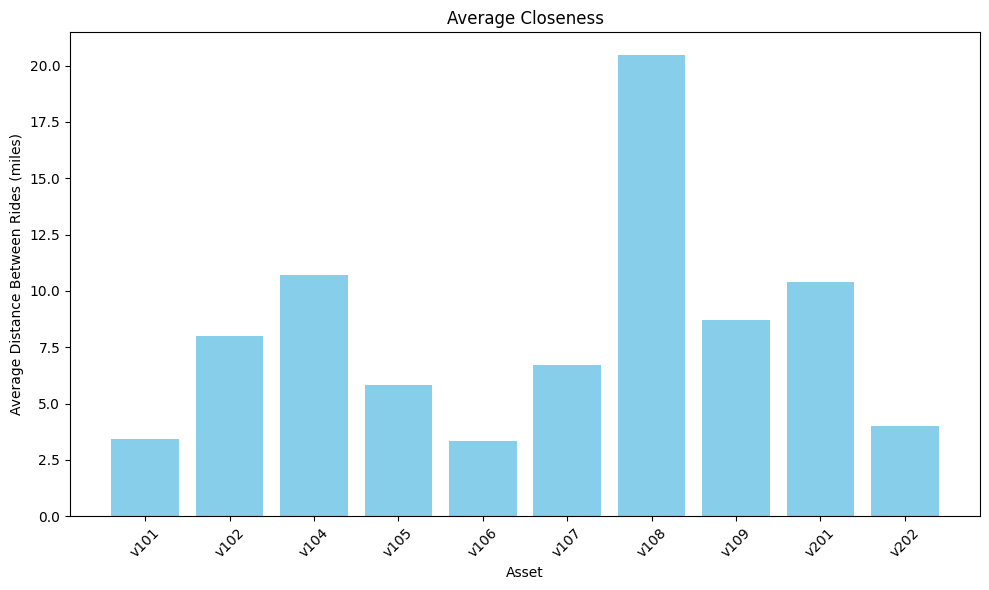

The bar chart above shows the Average Closeness for each asset. This helps visualize the efficiency of each asset in terms of the specific metric. Lower values indicate better performance for each metric.


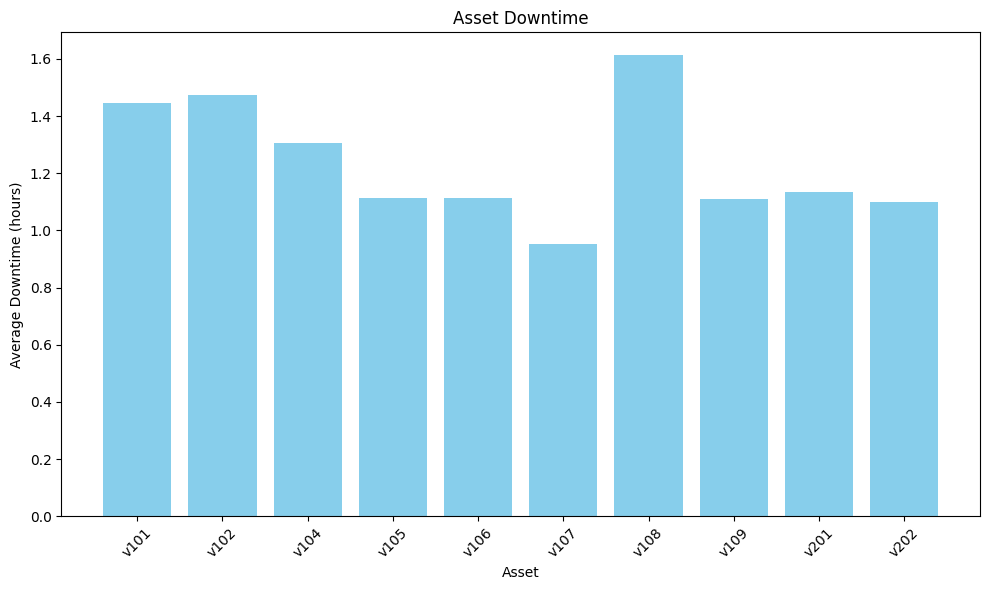

The bar chart above shows the Asset Downtime for each asset. This helps visualize the efficiency of each asset in terms of the specific metric. Lower values indicate better performance for each metric.


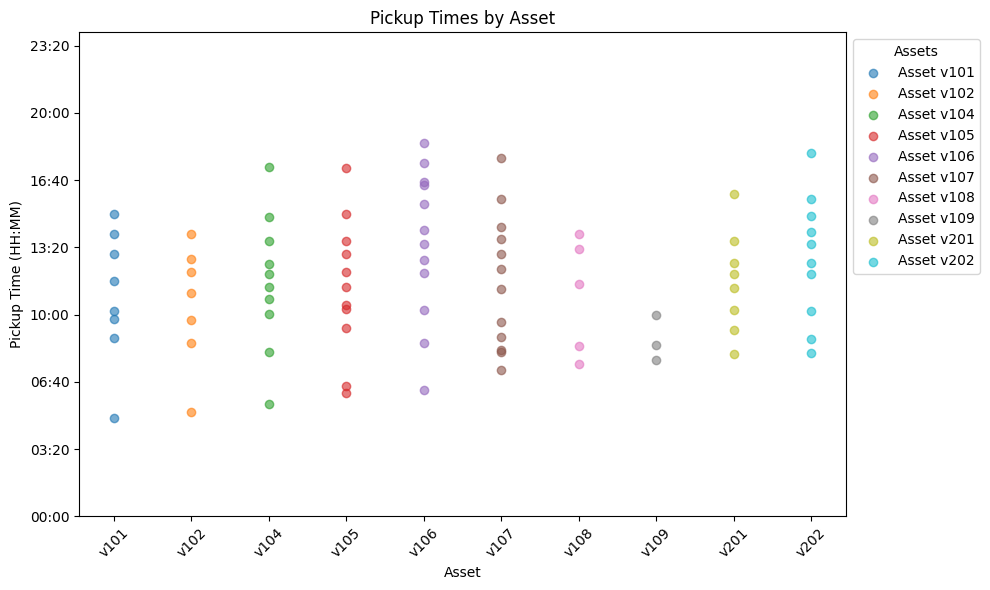

The scatter plot above shows the pickup times for each asset. Each point represents a ride, and the y-axis shows the pickup time in minutes. The x-axis indicates the asset to which the ride is assigned. This visualization helps to understand how evenly the rides are distributed across different assets over time.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def calculate_metrics(schedule):
    # Ensure distance is a float and pickup_time is a datetime
    schedule['distance'] = schedule['distance'].astype(float)
    schedule['pickup_time'] = pd.to_datetime(schedule['pickup_time'])

    metrics = {}

    # Calculate the number of rides for each asset
    num_rides_per_asset = schedule['asset'].value_counts().to_dict()

    # Calculate Mile Efficiency (variance of distances per asset)
    mile_efficiency = (
        schedule.groupby('asset')['distance'].apply(lambda x: x.var() * len(x) / num_rides_per_asset[x.name]).fillna(0).to_dict()
    )

    # Calculate Time Efficiency (standard deviation of pickup times per asset in minutes)
    schedule['pickup_minutes'] = schedule['pickup_time'].dt.hour * 60 + \
                                 schedule['pickup_time'].dt.minute + \
                                 schedule['pickup_time'].dt.second / 60
    time_efficiency = (
        schedule.groupby('asset')['pickup_minutes'].apply(lambda x: x.std() * len(x) / num_rides_per_asset[x.name]).fillna(0).to_dict()
    )

    # Calculate Average Closeness (average distance between consecutive rides per asset)
    def calculate_average_closeness(group):
        distances = group.sort_values('pickup_time')['distance'].values
        if len(distances) < 2:
            return 0
        return np.mean(np.abs(np.diff(distances))) * len(distances) / num_rides_per_asset[group.asset.iloc[0]]

    average_closeness = (
        schedule.groupby('asset').apply(calculate_average_closeness).to_dict()
    )

    metrics['mile_efficiency'] = mile_efficiency
    metrics['time_efficiency'] = time_efficiency
    metrics['average_closeness'] = average_closeness

    # Calculate Asset Downtime (time between consecutive pickups)
    def calculate_asset_downtime(schedule):
        # Ensure pickup_time is a datetime object
        schedule['pickup_time'] = pd.to_datetime(schedule['pickup_time'])
        
        # Sort the data by asset and pickup time
        schedule = schedule.sort_values(by=['asset', 'pickup_time'])
        
        # Calculate downtime between consecutive pickups for each asset
        schedule['downtime'] = schedule.groupby('asset')['pickup_time'].diff().dt.total_seconds() / 3600  # downtime in hours
        
        # We want to calculate average downtime per asset (higher downtime is worse)
        downtime_per_asset = schedule.groupby('asset')['downtime'].apply(lambda x: x.mean() * len(x) / num_rides_per_asset[x.name]).fillna(0)  # Use 0 for the first ride of each asset

        return downtime_per_asset

    # Adding downtime metric to the metrics
    downtime_per_asset = calculate_asset_downtime(schedule)
    metrics['asset_downtime'] = downtime_per_asset.to_dict()

    # Calculate scores for each metric
    scores = {}

    # Mile Efficiency Score (lower is better, ideal is 0)
    scores['mile_efficiency_score'] = {asset: 0 if value == 0 else value for asset, value in mile_efficiency.items()}

    # Time Efficiency Score (lower is better, ideal is 0)
    scores['time_efficiency_score'] = {asset: 0 if value == 0 else value for asset, value in time_efficiency.items()}

    # Average Closeness Score (lower is better, ideal is 0)
    scores['average_closeness_score'] = {asset: 0 if value == 0 else value for asset, value in average_closeness.items()}

    # Pickup Times Score: Ideally close together, so the smaller the better (we use the average of differences for this)
    def calculate_pickup_times_score(group):
        pickup_times = group['pickup_minutes'].values
        if len(pickup_times) < 2:
            return 0
        diffs = np.abs(np.diff(pickup_times))
        return np.mean(diffs) * len(pickup_times) / num_rides_per_asset[group.asset.iloc[0]]
    
    pickup_times_score = schedule.groupby('asset').apply(calculate_pickup_times_score).to_dict()

    scores['pickup_times_score'] = pickup_times_score

    return metrics, scores

def calculate_bottom_line_score(scores):
    bottom_line_scores = {}
    for asset in scores['mile_efficiency_score'].keys():
        # Average of all scores for each asset
        scores_for_asset = [
            scores['mile_efficiency_score'][asset],
            scores['time_efficiency_score'][asset],
            scores['average_closeness_score'][asset],
            scores['pickup_times_score'][asset]
        ]
        bottom_line_scores[asset] = np.mean(scores_for_asset)
    return bottom_line_scores

def calculate_variance_scalars(metrics, scores=None):
    variance_scalars = {}

    # Variance for raw metrics (distance, pickup time, etc.)
    for metric_name, metric_data in metrics.items():
        variance_scalars[metric_name] = np.var(list(metric_data.values()))
    
    # Variance for scores (mile_efficiency_score, time_efficiency_score, etc.)
    if scores:
        for score_name, score_data in scores.items():
            variance_scalars[score_name] = np.var(list(score_data.values()))
    
    return variance_scalars

def print_summary(metrics, scores, bottom_line_scores, variance_scalars):
    print("Summary of Key Metrics and Variance Scores:")
    
    # Print variance and standard deviation for each metric
    for metric_name, metric_data in metrics.items():
        print(f"\n--- {metric_name.replace('_', ' ').title()} ---")
        for asset, value in metric_data.items():
            print(f"Asset {asset}: {value:.2f}")
        
        metric_variance = variance_scalars.get(metric_name, 0)
        print(f"Total variance for {metric_name.replace('_', ' ').title()}: {metric_variance:.2f}")
        print(f"Standard deviation for {metric_name.replace('_', ' ').title()}: {np.sqrt(metric_variance):.2f}")

    # Print bottom line scores
    print("\n--- Bottom Line Scores ---")
    for asset, bottom_line_score in bottom_line_scores.items():
        print(f"Asset {asset}: {bottom_line_score:.2f}")

    print("\nVariance and Standard Deviation have been calculated for each metric and score, providing a breakdown of performance consistency across assets.")
    
def plot_scatter_pickup_times(schedule):
    # Ensure pickup time is in minutes
    schedule['pickup_minutes'] = schedule['pickup_time'].dt.hour * 60 + \
                                 schedule['pickup_time'].dt.minute + \
                                 schedule['pickup_time'].dt.second / 60

    plt.figure(figsize=(10, 6))
    for asset in schedule['asset'].unique():
        asset_data = schedule[schedule['asset'] == asset]
        plt.scatter([asset] * len(asset_data), asset_data['pickup_minutes'], alpha=0.6, label=f"Asset {asset}")
    
    plt.title('Pickup Times by Asset')
    plt.xlabel('Asset')
    
    # Set y-axis from 0 to 1440 (minutes in a day)
    plt.ylabel('Pickup Time (HH:MM)')
    plt.ylim(0, 1440)
    
    # Set the y-axis ticks to be in hours and minutes format
    def time_formatter(x, pos):
        return f'{int(x // 60):02d}:{int(x % 60):02d}'
    
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(time_formatter))
    
    plt.xticks(rotation=45)
    
    # Move legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Assets")
    
    # Adjust layout to fit everything
    plt.tight_layout()

    plt.show()

    # Explanation under the plot
    print("The scatter plot above shows the pickup times for each asset. Each point represents a ride, "
          "and the y-axis shows the pickup time in minutes. The x-axis indicates the asset to which the ride is assigned. "
          "This visualization helps to understand how evenly the rides are distributed across different assets over time.")

def plot_metrics(metrics):
    y_labels = {
        'mile_efficiency': 'Variance in Distance (miles²)',
        'time_efficiency': 'Standard Deviation in Pickup Time (minutes)',
        'average_closeness': 'Average Distance Between Rides (miles)',
        'asset_downtime': 'Average Downtime (hours)'
    }

    for metric_name, metric_data in metrics.items():
        assets = list(metric_data.keys())
        values = list(metric_data.values())

        plt.figure(figsize=(10, 6))
        plt.bar(assets, values, color='skyblue')
        plt.title(metric_name.replace('_', ' ').title())
        plt.xlabel('Asset')
        plt.ylabel(y_labels.get(metric_name, 'Value'))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Explanation under the plot
        print(f"The bar chart above shows the {metric_name.replace('_', ' ').title()} for each asset. "
              "This helps visualize the efficiency of each asset in terms of the specific metric. "
              "Lower values indicate better performance for each metric.")

if __name__ == "__main__":
    # Load the finalized schedule from a CSV file (replace 'schedule.csv' with your file path)
    # schedule = pd.read_csv(r'C:\Users\cyberwitch\Documents\portfolio\ALTR_PROJECT\Schedule-24-10-28 - schedule-24-10-28.csv')
    schedule = pd.read_csv(r'C:\Users\cyberwitch\Documents\portfolio\ALTR_PROJECT\2024-10-28_human-converted.csv')
    
    # Ensure the pickup_time column is a datetime object
    schedule['pickup_time'] = pd.to_datetime(schedule['pickup_time'])

    # Calculate metrics and scores
    metrics, scores = calculate_metrics(schedule)
    
    # Calculate bottom line scores
    bottom_line_scores = calculate_bottom_line_score(scores)
    
    # Calculate variance scalars
    variance_scalars = calculate_variance_scalars(metrics, scores)
    
    # Print summary
    print_summary(metrics, scores, bottom_line_scores, variance_scalars)
    
    # Plot metrics like variance, time efficiency, and closeness
    plot_metrics(metrics)
    
    # Plot pickup times by asset
    plot_scatter_pickup_times(schedule)


Summary of Key Metrics and Variance Scores:

--- Mile Efficiency ---
Asset v101: 148.61
Asset v102: 56.96
Asset v104: 58.30
Asset v105: 24.46
Asset v106: 13.63
Asset v107: 32.62
Asset v108: 109.10
Asset v109: 130.94
Asset v201: 15.81
Asset v202: 39.03
Total variance for Mile Efficiency: 2177.62
Standard deviation for Mile Efficiency: 46.66

--- Time Efficiency ---
Asset v101: 174.08
Asset v102: 221.51
Asset v104: 211.57
Asset v105: 256.16
Asset v106: 196.40
Asset v107: 211.27
Asset v108: 119.90
Asset v109: 106.72
Asset v201: 199.40
Asset v202: 142.49
Total variance for Time Efficiency: 2040.99
Standard deviation for Time Efficiency: 45.18

--- Average Closeness ---
Asset v101: 11.93
Asset v102: 6.80
Asset v104: 6.88
Asset v105: 6.40
Asset v106: 3.39
Asset v107: 7.45
Asset v108: 12.21
Asset v109: 12.11
Asset v201: 3.31
Asset v202: 6.57
Total variance for Average Closeness: 10.00
Standard deviation for Average Closeness: 3.16

--- Asset Downtime ---
Asset v101: 1.30
Asset v102: 1.14
Asse

C:\Users\cyberwitch\AppData\Local\Temp\ipykernel_17528\656373790.py:208: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  schedule['pickup_time'] = pd.to_datetime(schedule['pickup_time'])
C:\Users\cyberwitch\AppData\Local\Temp\ipykernel_17528\656373790.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedule.groupby('asset').apply(calculate_average_closeness).to_dict()
C:\Users\cyberwitch\AppData\Local\Temp\ipykernel_17528\656373790.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a futu

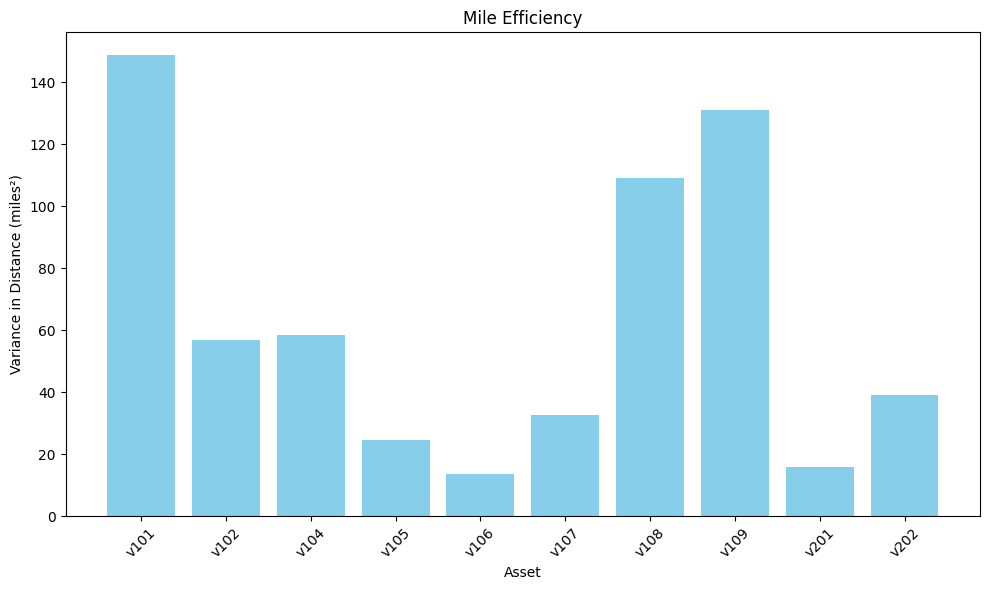

The bar chart above shows the Mile Efficiency for each asset. This helps visualize the efficiency of each asset in terms of the specific metric. Lower values indicate better performance for each metric.


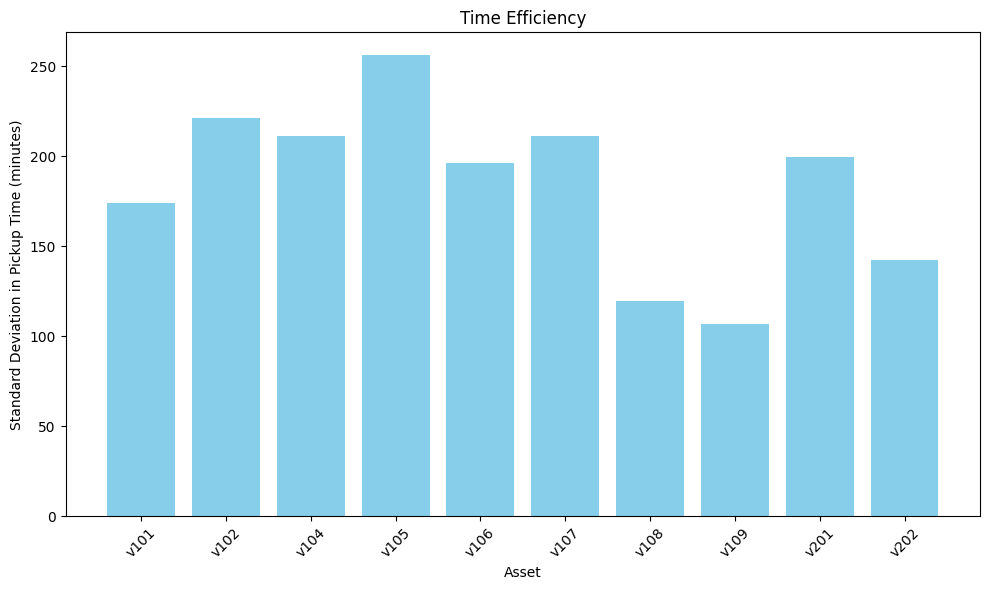

The bar chart above shows the Time Efficiency for each asset. This helps visualize the efficiency of each asset in terms of the specific metric. Lower values indicate better performance for each metric.


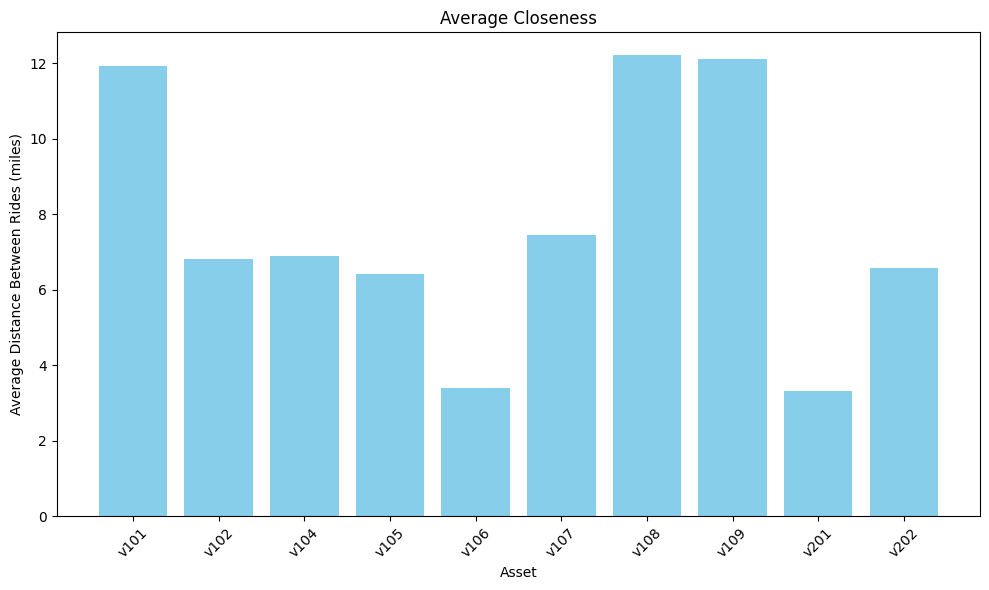

The bar chart above shows the Average Closeness for each asset. This helps visualize the efficiency of each asset in terms of the specific metric. Lower values indicate better performance for each metric.


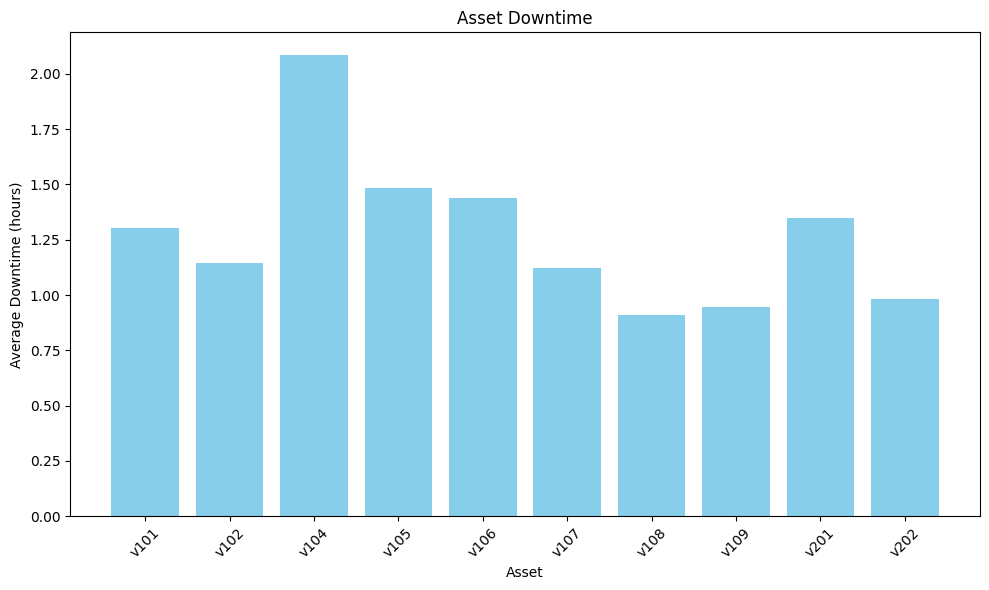

The bar chart above shows the Asset Downtime for each asset. This helps visualize the efficiency of each asset in terms of the specific metric. Lower values indicate better performance for each metric.


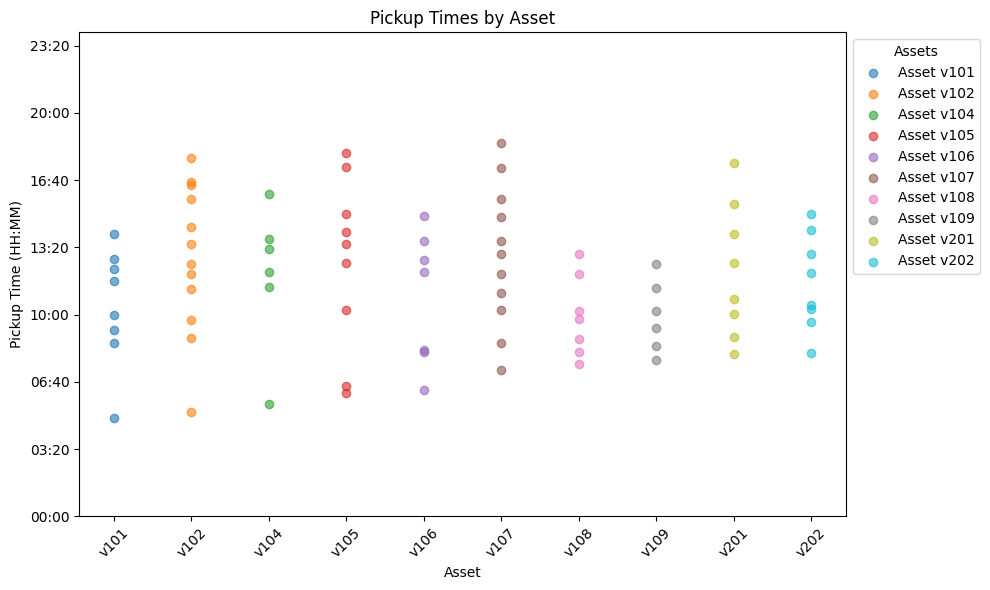

The scatter plot above shows the pickup times for each asset. Each point represents a ride, and the y-axis shows the pickup time in minutes. The x-axis indicates the asset to which the ride is assigned. This visualization helps to understand how evenly the rides are distributed across different assets over time.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def calculate_metrics(schedule):
    # Ensure distance is a float and pickup_time is a datetime
    schedule['distance'] = schedule['distance'].astype(float)
    schedule['pickup_time'] = pd.to_datetime(schedule['pickup_time'])

    metrics = {}

    # Calculate the number of rides for each asset
    num_rides_per_asset = schedule['asset'].value_counts().to_dict()

    # Calculate Mile Efficiency (variance of distances per asset)
    mile_efficiency = (
        schedule.groupby('asset')['distance'].apply(lambda x: x.var() * len(x) / num_rides_per_asset[x.name]).fillna(0).to_dict()
    )

    # Calculate Time Efficiency (standard deviation of pickup times per asset in minutes)
    schedule['pickup_minutes'] = schedule['pickup_time'].dt.hour * 60 + \
                                 schedule['pickup_time'].dt.minute + \
                                 schedule['pickup_time'].dt.second / 60
    time_efficiency = (
        schedule.groupby('asset')['pickup_minutes'].apply(lambda x: x.std() * len(x) / num_rides_per_asset[x.name]).fillna(0).to_dict()
    )

    # Calculate Average Closeness (average distance between consecutive rides per asset)
    def calculate_average_closeness(group):
        distances = group.sort_values('pickup_time')['distance'].values
        if len(distances) < 2:
            return 0
        return np.mean(np.abs(np.diff(distances))) * len(distances) / num_rides_per_asset[group.asset.iloc[0]]

    average_closeness = (
        schedule.groupby('asset').apply(calculate_average_closeness).to_dict()
    )

    metrics['mile_efficiency'] = mile_efficiency
    metrics['time_efficiency'] = time_efficiency
    metrics['average_closeness'] = average_closeness

    # Calculate Asset Downtime (time between consecutive pickups)
    def calculate_asset_downtime(schedule):
        # Ensure pickup_time is a datetime object
        schedule['pickup_time'] = pd.to_datetime(schedule['pickup_time'])
        
        # Sort the data by asset and pickup time
        schedule = schedule.sort_values(by=['asset', 'pickup_time'])
        
        # Calculate downtime between consecutive pickups for each asset
        schedule['downtime'] = schedule.groupby('asset')['pickup_time'].diff().dt.total_seconds() / 3600  # downtime in hours
        
        # We want to calculate average downtime per asset (higher downtime is worse)
        downtime_per_asset = schedule.groupby('asset')['downtime'].apply(lambda x: x.mean() * len(x) / num_rides_per_asset[x.name]).fillna(0)  # Use 0 for the first ride of each asset

        return downtime_per_asset

    # Adding downtime metric to the metrics
    downtime_per_asset = calculate_asset_downtime(schedule)
    metrics['asset_downtime'] = downtime_per_asset.to_dict()

    # Calculate scores for each metric
    scores = {}

    # Mile Efficiency Score (lower is better, ideal is 0)
    scores['mile_efficiency_score'] = {asset: 0 if value == 0 else value for asset, value in mile_efficiency.items()}

    # Time Efficiency Score (lower is better, ideal is 0)
    scores['time_efficiency_score'] = {asset: 0 if value == 0 else value for asset, value in time_efficiency.items()}

    # Average Closeness Score (lower is better, ideal is 0)
    scores['average_closeness_score'] = {asset: 0 if value == 0 else value for asset, value in average_closeness.items()}

    # Pickup Times Score: Ideally close together, so the smaller the better (we use the average of differences for this)
    def calculate_pickup_times_score(group):
        pickup_times = group['pickup_minutes'].values
        if len(pickup_times) < 2:
            return 0
        diffs = np.abs(np.diff(pickup_times))
        return np.mean(diffs) * len(pickup_times) / num_rides_per_asset[group.asset.iloc[0]]
    
    pickup_times_score = schedule.groupby('asset').apply(calculate_pickup_times_score).to_dict()

    scores['pickup_times_score'] = pickup_times_score

    return metrics, scores

def calculate_bottom_line_score(scores):
    bottom_line_scores = {}
    for asset in scores['mile_efficiency_score'].keys():
        # Average of all scores for each asset
        scores_for_asset = [
            scores['mile_efficiency_score'][asset],
            scores['time_efficiency_score'][asset],
            scores['average_closeness_score'][asset],
            scores['pickup_times_score'][asset]
        ]
        bottom_line_scores[asset] = np.mean(scores_for_asset)
    return bottom_line_scores

def calculate_variance_scalars(metrics, scores=None):
    variance_scalars = {}

    # Variance for raw metrics (distance, pickup time, etc.)
    for metric_name, metric_data in metrics.items():
        variance_scalars[metric_name] = np.var(list(metric_data.values()))
    
    # Variance for scores (mile_efficiency_score, time_efficiency_score, etc.)
    if scores:
        for score_name, score_data in scores.items():
            variance_scalars[score_name] = np.var(list(score_data.values()))
    
    return variance_scalars

def print_summary(metrics, scores, bottom_line_scores, variance_scalars):
    print("Summary of Key Metrics and Variance Scores:")
    
    # Print variance and standard deviation for each metric
    for metric_name, metric_data in metrics.items():
        print(f"\n--- {metric_name.replace('_', ' ').title()} ---")
        for asset, value in metric_data.items():
            print(f"Asset {asset}: {value:.2f}")
        
        metric_variance = variance_scalars.get(metric_name, 0)
        print(f"Total variance for {metric_name.replace('_', ' ').title()}: {metric_variance:.2f}")
        print(f"Standard deviation for {metric_name.replace('_', ' ').title()}: {np.sqrt(metric_variance):.2f}")

    # Print bottom line scores
    print("\n--- Bottom Line Scores ---")
    for asset, bottom_line_score in bottom_line_scores.items():
        print(f"Asset {asset}: {bottom_line_score:.2f}")

    print("\nVariance and Standard Deviation have been calculated for each metric and score, providing a breakdown of performance consistency across assets.")
    
def plot_scatter_pickup_times(schedule):
    # Ensure pickup time is in minutes
    schedule['pickup_minutes'] = schedule['pickup_time'].dt.hour * 60 + \
                                 schedule['pickup_time'].dt.minute + \
                                 schedule['pickup_time'].dt.second / 60

    plt.figure(figsize=(10, 6))
    for asset in schedule['asset'].unique():
        asset_data = schedule[schedule['asset'] == asset]
        plt.scatter([asset] * len(asset_data), asset_data['pickup_minutes'], alpha=0.6, label=f"Asset {asset}")
    
    plt.title('Pickup Times by Asset')
    plt.xlabel('Asset')
    
    # Set y-axis from 0 to 1440 (minutes in a day)
    plt.ylabel('Pickup Time (HH:MM)')
    plt.ylim(0, 1440)
    
    # Set the y-axis ticks to be in hours and minutes format
    def time_formatter(x, pos):
        return f'{int(x // 60):02d}:{int(x % 60):02d}'
    
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(time_formatter))
    
    plt.xticks(rotation=45)
    
    # Move legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Assets")
    
    # Adjust layout to fit everything
    plt.tight_layout()

    plt.show()

    # Explanation under the plot
    print("The scatter plot above shows the pickup times for each asset. Each point represents a ride, "
          "and the y-axis shows the pickup time in minutes. The x-axis indicates the asset to which the ride is assigned. "
          "This visualization helps to understand how evenly the rides are distributed across different assets over time.")

def plot_metrics(metrics):
    y_labels = {
        'mile_efficiency': 'Variance in Distance (miles²)',
        'time_efficiency': 'Standard Deviation in Pickup Time (minutes)',
        'average_closeness': 'Average Distance Between Rides (miles)',
        'asset_downtime': 'Average Downtime (hours)'
    }

    for metric_name, metric_data in metrics.items():
        assets = list(metric_data.keys())
        values = list(metric_data.values())

        plt.figure(figsize=(10, 6))
        plt.bar(assets, values, color='skyblue')
        plt.title(metric_name.replace('_', ' ').title())
        plt.xlabel('Asset')
        plt.ylabel(y_labels.get(metric_name, 'Value'))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Explanation under the plot
        print(f"The bar chart above shows the {metric_name.replace('_', ' ').title()} for each asset. "
              "This helps visualize the efficiency of each asset in terms of the specific metric. "
              "Lower values indicate better performance for each metric.")

if __name__ == "__main__":
    # Load the finalized schedule from a CSV file (replace 'schedule.csv' with your file path)
    # schedule = pd.read_csv(r'C:\Users\cyberwitch\Documents\portfolio\ALTR_PROJECT\Schedule-24-10-28 - schedule-24-10-28.csv')
    schedule = pd.read_csv(r'C:\Users\cyberwitch\Documents\portfolio\ALTR_PROJECT\agent_schedule_2024_10_31_converted.csv')
    
    # Ensure the pickup_time column is a datetime object
    schedule['pickup_time'] = pd.to_datetime(schedule['pickup_time'])

    # Calculate metrics and scores
    metrics, scores = calculate_metrics(schedule)
    
    # Calculate bottom line scores
    bottom_line_scores = calculate_bottom_line_score(scores)
    
    # Calculate variance scalars
    variance_scalars = calculate_variance_scalars(metrics, scores)
    
    # Print summary
    print_summary(metrics, scores, bottom_line_scores, variance_scalars)
    
    # Plot metrics like variance, time efficiency, and closeness
    plot_metrics(metrics)
    
    # Plot pickup times by asset
    plot_scatter_pickup_times(schedule)
